In [1]:
import csv
import numpy as np
import pandas as pd

Take a stock, find what cluster it is in

In [2]:
df = pd.read_csv('sp500_tickers_full_info.csv')

In [3]:
numeric_columns = df.select_dtypes(include=['number'])

In [4]:
df_numeric = df[['Ticker','sector']].join(df.select_dtypes(include=['number']))

In [5]:
# Check for infinity or NaN values
df_numeric = df_numeric.replace([np.inf, -np.inf], np.nan)
# Select only numeric columns and fill NaNs with their mean
numeric_cols = df_numeric.select_dtypes(include=["number"])
df_numeric[numeric_cols.columns] = numeric_cols.fillna(numeric_cols.mean())

In [6]:
# Create a correlation matrix
numeric_features = df_numeric.drop(columns=["Ticker", "sector"])
correlation_matrix = numeric_features.corr().abs()

# Select upper triangle of correlation matrix
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)

# Find features with correlation > 0.85 (adjust threshold as needed)
high_correlation_features = [
    column for column in upper_triangle.columns if any(upper_triangle[column] > 0.85)
]

# Drop highly correlated features
numeric_features_reduced = numeric_features.drop(columns=high_correlation_features)
print(f"Reduced features from {numeric_features.shape[1]} to {numeric_features_reduced.shape[1]}")


Reduced features from 101 to 60


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Scale numeric features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_features_reduced)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=75, init="k-means++", random_state=42)
df_numeric["Cluster"] = kmeans.fit_predict(scaled_features)


In [8]:
df_numeric_with_cluster = df[["Ticker", "sector"]].join(df_numeric[["Cluster"]])
df_numeric_with_cluster.head()

,Ticker,sector,Cluster
0,MMM,Industrials,6
1,AOS,Industrials,31
2,ABT,Healthcare,6
3,ABBV,Healthcare,23
4,ACN,Technology,43


In [9]:
# Compute and sort cluster distribution
cluster_distribution = df_numeric_with_cluster["Cluster"].value_counts().sort_values(ascending=False)
cluster_distribution

1     45
16    37
20    30
44    28
6     25
      ..
28     1
26     1
47     1
22     1
42     1
Name: Cluster, Length: 75, dtype: int64

In [10]:
(cluster_distribution == 1).astype(int).sum()

30

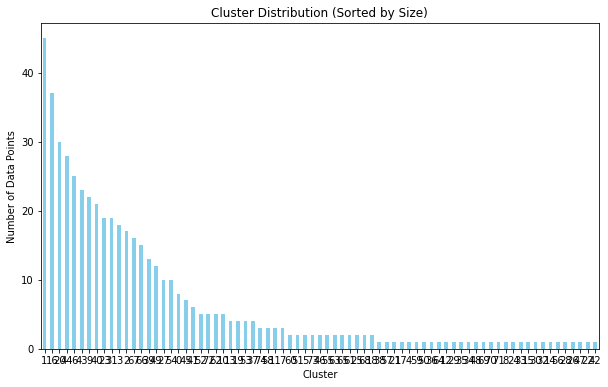

In [11]:
import matplotlib.pyplot as plt

# Plot cluster distribution (sorted)
plt.figure(figsize=(10, 6))
cluster_distribution.plot(kind="bar", color="skyblue")
plt.title("Cluster Distribution (Sorted by Size)")
plt.xlabel("Cluster")
plt.ylabel("Number of Data Points")
plt.xticks(rotation=0)
plt.show()
